In [1]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import numpy as np
import warnings
import requests

In [2]:

warnings.filterwarnings('ignore')

In [3]:
# function to connect to wiki_dbs and query
def connect_and_query(wiki_name, query, cnf_path = "/home/paws/.my.cnf"):
    
    conn = pymysql.connect(host = wiki_name + '.analytics.db.svc.wikimedia.cloud',
                           read_default_file = cnf_path,
                           database = wiki_name + '_p')
    
    with conn.cursor() as cur:
        cur.execute(query)
        data = cur.fetchall()
    
    conn.close()
    return data

In [4]:
wikis = ['tewiki', 'hiwiki', 'mlwiki']
all_dfs = []

**Edits by Platform**  
This plot shows the number of monthly edits made from different platforms (such as desktop and mobile web) over time across tewiki, hiwiki, and mlwiki.


In [5]:
query_url = "https://raw.githubusercontent.com/BhargaviVyshnavi20/community-insights-dashboard-tooling/main/Edits_by_platform.sql"
query1 = requests.get(query_url).text

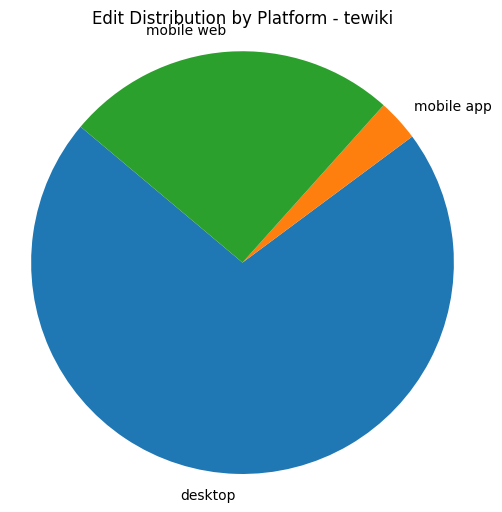

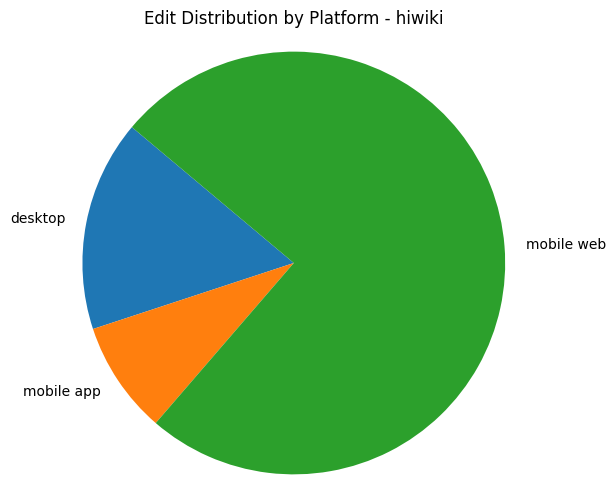

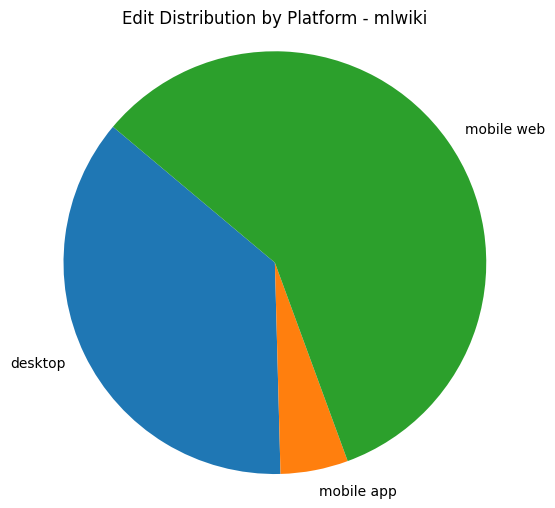

In [6]:
# Function to run the same SQL query across multiple wiki databases
def run_query_for_wikis(wikis, query):
    results = []
    for wiki in wikis:
        output = connect_and_query(wiki, query)
        df = pd.DataFrame(output, columns=['platform', 'edit_count'])
        df['wiki'] = wiki
        results.append(df)
    return pd.concat(results, ignore_index=True)

combined_df = run_query_for_wikis(wikis, query1)


# Plot pie charts for each wiki showing edit distribution by platform
for wiki in combined_df['wiki'].unique():
    temp = combined_df[combined_df['wiki'] == wiki]
    plt.figure(figsize=(6, 6))
    plt.pie(temp['edit_count'], labels=temp['platform'], startangle=140)
    plt.title(f'Edit Distribution by Platform - {wiki}')
    plt.axis('equal')
    plt.show()

**Monthly Active Editors – Rolling YoY**  
The plot shows the monthly number of active editors for each wiki (`tewiki`, `hiwiki`, `mlwiki`) along with a 3-month moving average line.


In [7]:
query_url = "https://raw.githubusercontent.com/BhargaviVyshnavi20/community-insights-dashboard-tooling/main/monthly_active_editors_rolling_yoy.sql"
query = requests.get(query_url).text


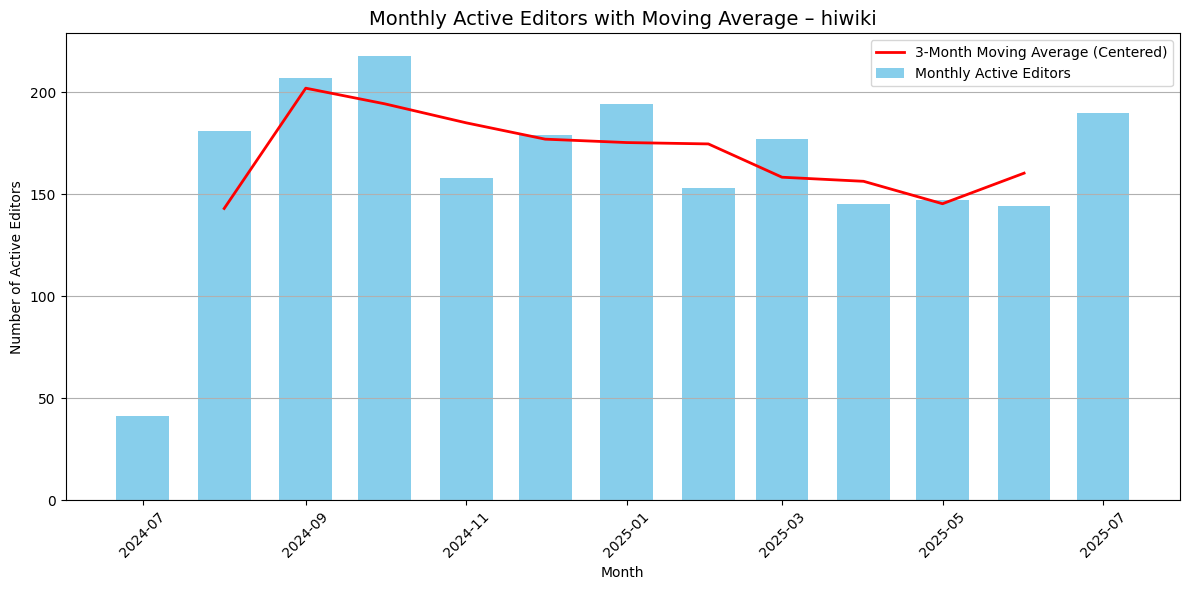

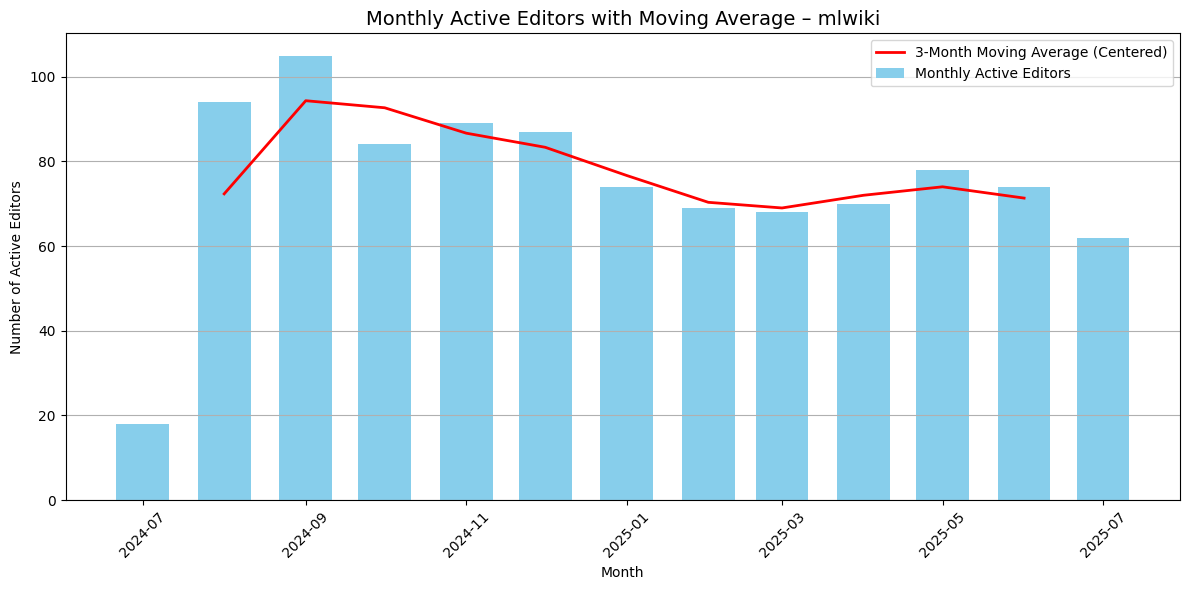

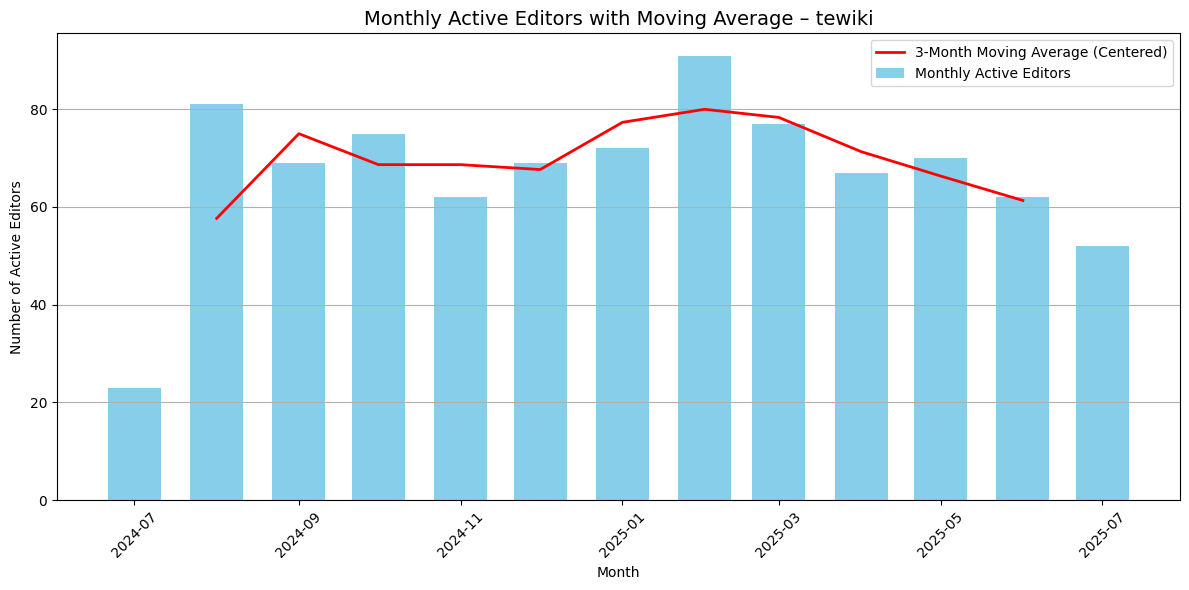

In [8]:
# Function to run the same SQL query across multiple wiki databases
for wiki in wikis:
    output = connect_and_query(wiki, query)  
    df = pd.DataFrame(output, columns=['year', 'month', 'edits'])
    df['wiki'] = wiki
    all_dfs.append(df)
combined_df = pd.concat(all_dfs, ignore_index=True)

# Create a datetime column from year and month for plotting
combined_df['date'] = pd.to_datetime(combined_df[['year', 'month']].assign(day=1))
combined_df = combined_df.sort_values(by=['wiki', 'date'])


# Plot active editors with 3-month moving average for each wiki
for wiki in combined_df['wiki'].unique():
    df = combined_df[combined_df['wiki'] == wiki].copy()

    # Calculate 3-month moving average
    df['3_month_moving_avg'] = df['edits'].rolling(window=3, center=True).mean()
    
    # Plot the bar chart and moving average line
    plt.figure(figsize=(12, 6))
    plt.bar(df['date'], df['edits'], width=20, color='skyblue', label='Monthly Active Editors')
    plt.plot(df['date'], df['3_month_moving_avg'], color='red', linewidth=2, label='3-Month Moving Average (Centered)')

    plt.title(f'Monthly Active Editors with Moving Average – {wiki}', fontsize=14)
    plt.xlabel('Month')
    plt.ylabel('Number of Active Editors')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


### **Content namespace page length**

This code collects page lengths from multiple wikis, converts them to kilobytes, and combines the data.  
It then plots a histogram for each wiki to show the distribution of page sizes.


In [9]:

query_url = "https://raw.githubusercontent.com/BhargaviVyshnavi20/community-insights-dashboard-tooling/main/Content_Namespace_Page_lengths.sql"
query3 = requests.get(query_url).text


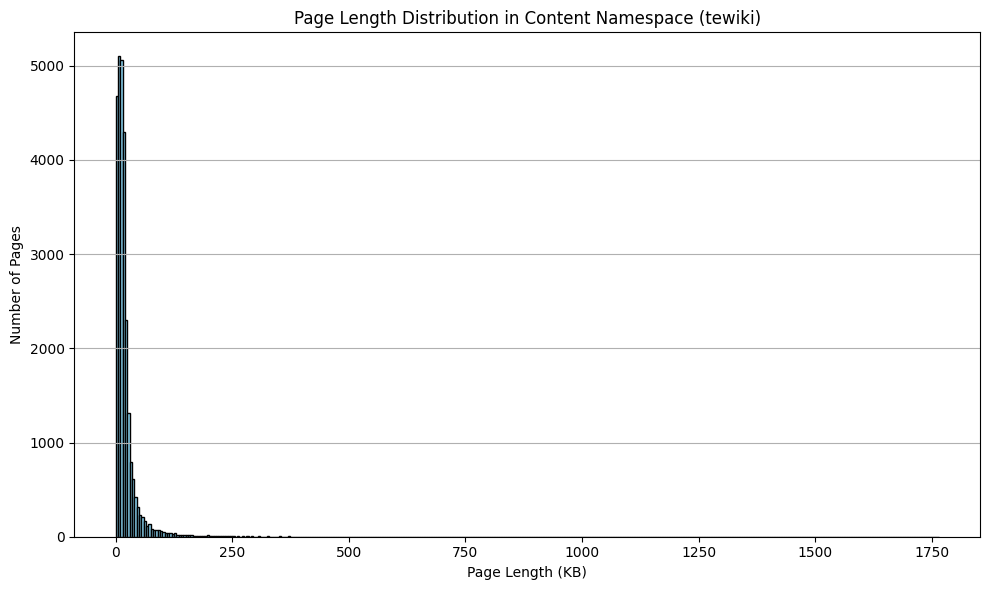

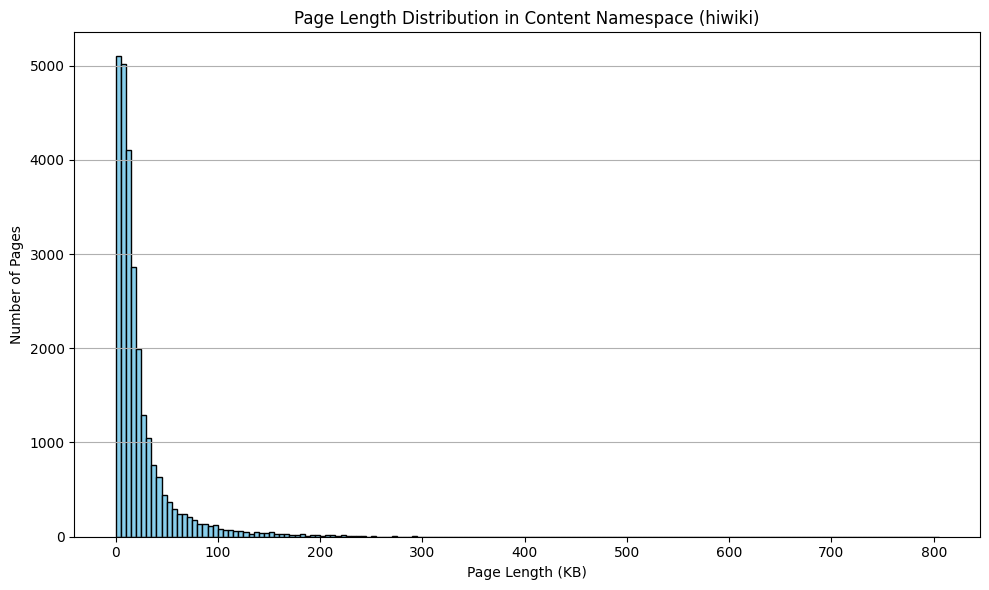

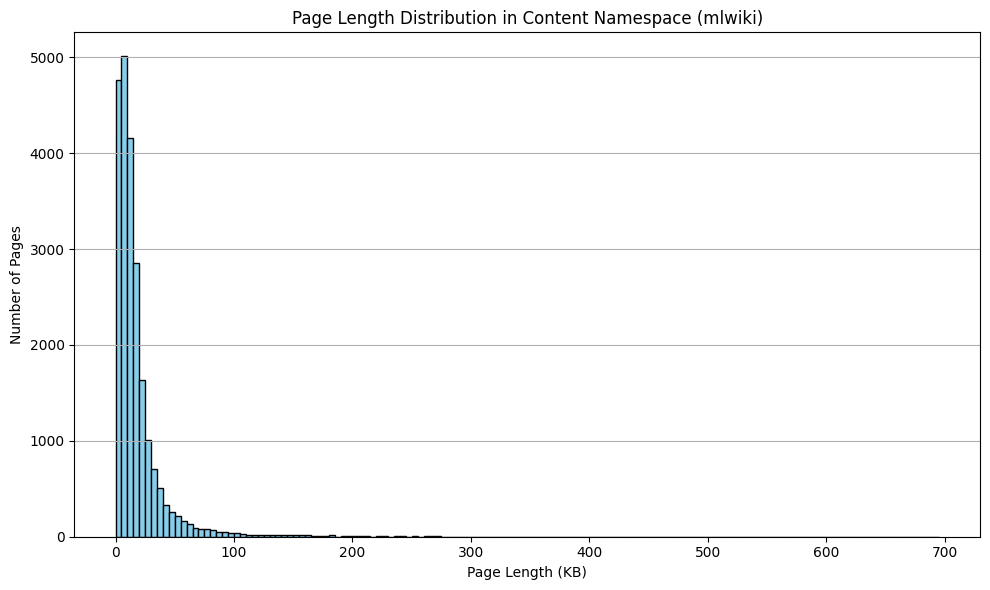

In [10]:
# Function to run the same SQL query across multiple wiki databases
for wiki in wikis:
    output = connect_and_query(wiki, query3)
    df = pd.DataFrame(output, columns=['page_length'])

    df['wiki'] = wiki
    all_dfs.append(df)


combined_df = pd.concat(all_dfs, ignore_index=True)

# Convert page length to kilobytes and handle any non-numeric values
combined_df['page_len_kb'] = pd.to_numeric(combined_df['page_length'], errors='coerce') / 1024
combined_df = combined_df.dropna(subset=['page_len_kb'])


for wiki in wikis:
    df = combined_df[combined_df['wiki'] == wiki]

    # Define bin ranges for histogram (5 KB intervals)
    bins = np.arange(0, df['page_len_kb'].max() + 5, 5)

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(df['page_len_kb'], bins=bins, color='skyblue', edgecolor='black')

    plt.xlabel('Page Length (KB)')
    plt.ylabel('Number of Pages')
    plt.title(f'Page Length Distribution in Content Namespace ({wiki})')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
